In [0]:
!pip install pytesseract
!apt install tesseract-ocr
!git clone https://github.com/ellerypan/MANGA-TRANSLATOR
!cp -r drive/My\ Drive/mlator_models /content/checkpoint
!mv MANGA-TRANSLATOR/* /content/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
fatal: destination path 'MANGA-TRANSLATOR' already exists and is not an empty directory.
cp: cannot create symbolic link '/content/checkpoint/mlator_models': Operation not supported
mv: cannot stat 'MANGA-TRANSLATOR/*': No such file or directory


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import cv2
import re
import PIL
import html
import time
import math
import textwrap
from models.unet import *
import numpy as np
from data import *
from PIL import Image
import skimage.io as io
from imageio import imread
import matplotlib.pyplot as plt
import skimage.transform as trans
from multiprocessing import Pool
import skimage.transform as trans
import xml.etree.ElementTree as ET
from keras.preprocessing import image

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.optimizers import Adam, SGD
from PIL import Image, ImageFont, ImageDraw
# from keras.models import load_model
import numpy as np
import pytesseract
from math import ceil
from matplotlib import pyplot as plt
from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
# from data_generator.object_detection_2d_data_generator_manga import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 32, 64, 100] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [0]:
%%time
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'checkpoint/ssd300_all.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=0.8)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

model2 = unet()
model2.load_weights("checkpoint/unet_8.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


/content/models/unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


CPU times: user 4.73 s, sys: 552 ms, total: 5.28 s
Wall time: 13.9 s


In [0]:
os.listdir('upload/needed/')

['06.jpg', '003.jpg', 'pFGsYGn.jpg']

In [0]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
# We'll only load one image in this example.
#27
img_path ='upload/needed/'+os.listdir('upload/needed/')[2]
# img_load = imread(img_path)
img_load = Image.open(img_path).convert("RGB")
    
orig_images.append(np.array(img_load))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

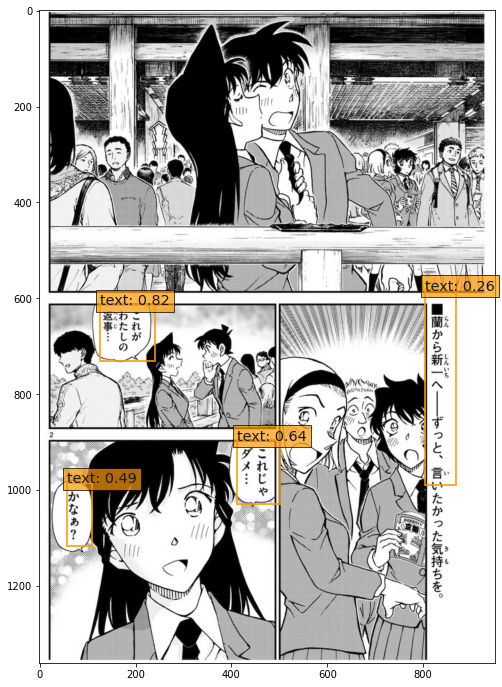

In [0]:
# 1: Set the generator for the predictions.
batch_original_images = orig_images
batch_images = input_images
# i = 0 # Which batch item to look at

# 2: Make predictions.
y_pred = model.predict(input_images)

# 3: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.17,
                                   iou_threshold=0.01,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 4: Convert the predictions for the original image + manual offset.
# decode
y_pred_decoded_inv = y_pred_decoded.copy()
y_pred_decoded_inv[0][:,2] = y_pred_decoded[0][:,2]* orig_images[0].shape[1] / img_width-3
y_pred_decoded_inv[0][:,3] = y_pred_decoded[0][:,3]* orig_images[0].shape[0] / img_height-3
y_pred_decoded_inv[0][:,4] = y_pred_decoded[0][:,4]* orig_images[0].shape[1] / img_width+28
y_pred_decoded_inv[0][:,5] = y_pred_decoded[0][:,5]* orig_images[0].shape[0] / img_height+28


np.set_printoptions(precision=2, suppress=True, linewidth=90)
i = 0
# 5: Draw the predicted boxes onto the image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','text']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[i])

current_axis = plt.gca()

for box in y_pred_decoded_inv[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color="#FF9900", fill=False, linewidth=2,alpha=0.8))  
    current_axis.text(xmin, ymin, label, size='x-large', color='#131A22', bbox={'facecolor':"#FF9900", 'alpha':0.7})    
    
# output text_box in this script
text_box = []
for y_pred_decode in y_pred_decoded_inv:
    text_box.append(y_pred_decode[:,2:].astype(np.int32))

In [0]:
w,h = img_load.size
h/w

1.4311251314405888

In [0]:
!wget https://raw.githubusercontent.com/ajperry2/MLator/master/server/nmt-API-07b7802bb743.json

--2020-05-27 20:44:22--  https://raw.githubusercontent.com/ajperry2/MLator/master/server/nmt-API-07b7802bb743.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2338 (2.3K) [text/plain]
Saving to: ‘nmt-API-07b7802bb743.json’

nmt-API-07b7802bb74 100%[===================>]   2.28K  --.-KB/s    in 0s      

2020-05-27 20:44:22 (35.0 MB/s) - ‘nmt-API-07b7802bb743.json’ saved [2338/2338]



In [0]:


# Imports the Google Cloud client library
from google.cloud import translate
import six
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="nmt-API-07b7802bb743.json"
# /Users/panziqi/Desktop/Mlator/ssd_keras/nmt-API-07b7802bb743.json
translate_client = translate.Client()
target = 'en'



In [0]:
class TransGT(object):
    def __init__(self, text, source_language ='ja'):
        self.text = text
        self.source_language = source_language
    def translator(self):
        translated = translate_client.translate(
            self.text,
            source_language = self.source_language,
            model=translate.NMT,
            format_='text'
            )
        result = []
        for tran in translated:
            result.append(tran['translatedText'])
        return result

In [0]:
def crop_words(img, boxes):
    """
    make sure that the vertices of all boxes are inside the image
    """
    words = []
    for j in range(len(boxes)):
        h, w = img.shape[:2]
        if boxes.shape[1] == 4:
            # box case
            box = boxes[j]
            xmin, ymin, xmax, ymax = box
            if xmin==xmax:
                xmax+=5
            if ymin==ymax:
                ymax+=5
            
            word_w, word_h = xmax - xmin, ymax - ymin
            word_ar = word_w / word_h
            word = img[ymin:ymax,xmin:xmax,:]
        words.append(word)
    return words

In [0]:
xmin, ymin, xmax, ymax = text_box[0][0]
image_patch = batch_original_images[0][ymin:ymax,xmin:xmax,:]
bg_color = np.quantile(image_patch[np.where(image_patch>220)],0.3)

In [0]:
len(text_box[0])

4

In [0]:
box_mask = np.zeros(batch_original_images[0].shape[:2])

for xmin, ymin, xmax, ymax in text_box[0]:
    box_mask[ymin:ymax,xmin:xmax]=1

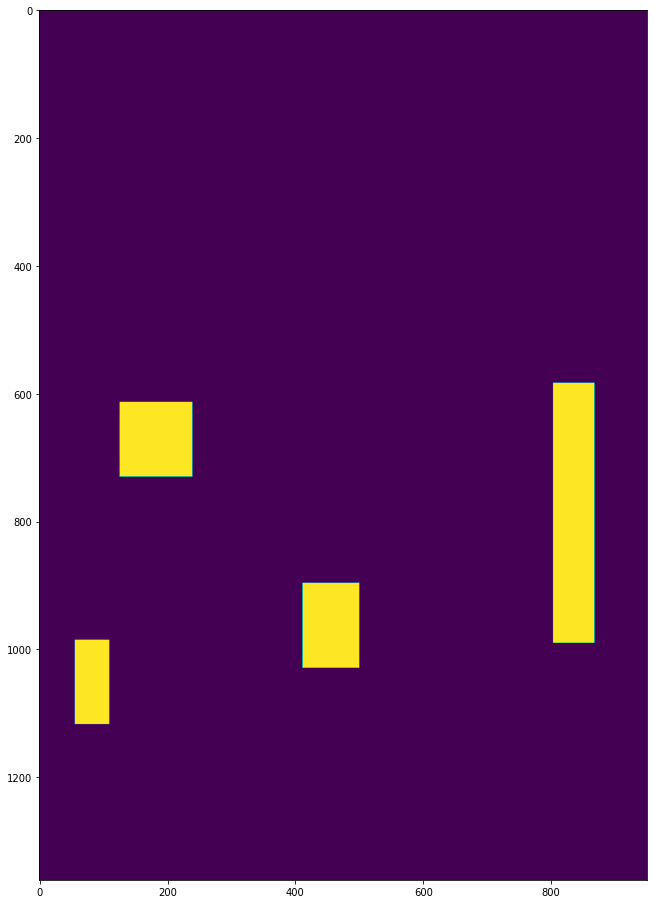

In [0]:
plt.figure(figsize=(16, 16))
plt.imshow(box_mask)

In [0]:
box_mask.shape

(1361, 951)

(1361, 951)
CPU times: user 3.91 s, sys: 221 ms, total: 4.13 s
Wall time: 2.19 s


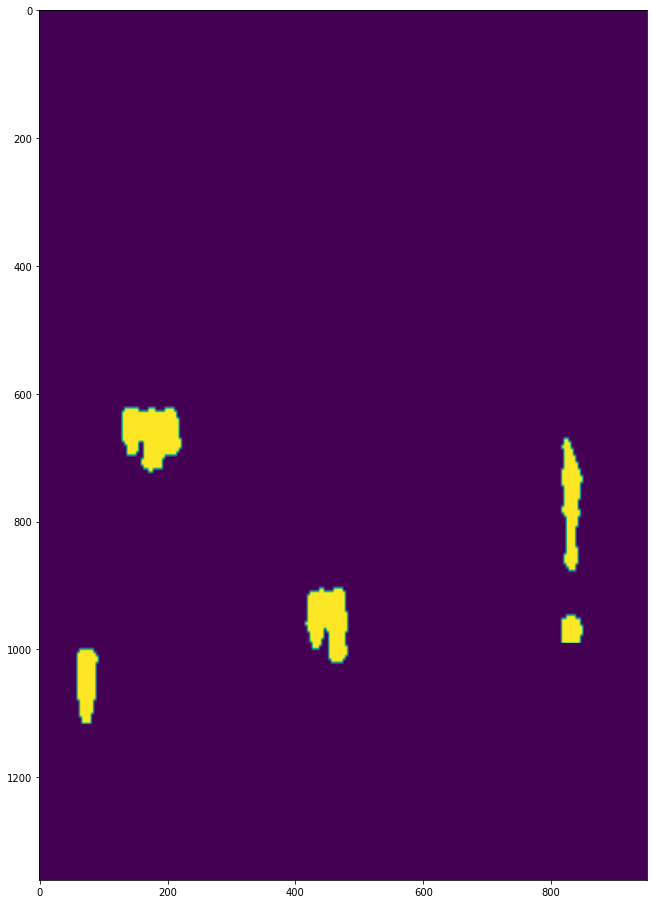

In [0]:
%%time
img_L = img_load.convert("L")
img_array = np.array(img_L)
sh = img_array.shape
print(sh)
img_rz = trans.resize(img_array,(256,256,1))
img_rz = np.expand_dims(img_rz,axis=0)
pred = model2.predict(img_rz)>0.2
mask = trans.resize(pred[0][:,:,0],sh)
mask = np.multiply(mask,box_mask)
plt.figure(figsize=(16, 16))
plt.imshow(mask)

In [0]:
mask.shape

(1361, 951)

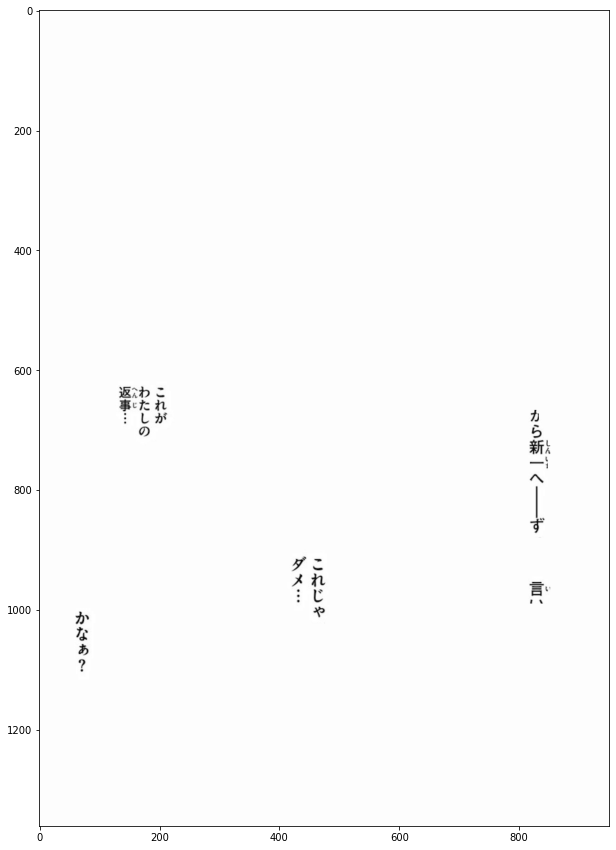

In [0]:
img_seg = np.array(img_load)
img_seg[mask==0]=bg_color

plt.figure(figsize=(15,15))
plt.imshow(img_seg)

In [0]:
%%time
text_ocr = []
crop_page = []
ocr_page = []
ocr_page_tran = []
text_ocr_tran = []
text_box_clean = []

r = re.compile(r'[-A-Za-z1-9(){}\[\]\【】/|~《》』\\<ぇー_]+')
r2 = re.compile(r'[二p:"=]+')

def ocr(image):
#     ret,image = cv2.threshold(image,117,250,cv2.THRESH_BINARY)
    t = pytesseract.image_to_string(image, lang='jpn',config="--psm 12 --oem 1")
    t = r.sub(' ',t).split()
    t = "".join(t)
    t = r2.sub('!!',t)
    return t

start = time.time()

cropped = crop_words(img_seg,text_box[0])

end = time.time()
print(start-end)

start = time.time()

cropped_filter = []
mask_text = []
for j in range(len(cropped)):
    h,w,_ = cropped[j].shape
#     if h<w/1.5:
#         continue
    cropped_filter.append(cropped[j])
    mask_text.append(j)

end = time.time()
print(start-end)

start = time.time()

text_box_clean.append(text_box[0][mask_text])

pool1=Pool(12)
text_ocr = pool1.map(ocr, cropped_filter)
pool1.close()
pool1.join()
end = time.time()
print(start-end)

start = time.time()

eng = TransGT(text_ocr)
text_ocr_tran = eng.translator()

end = time.time()
print(start-end)

crop_page.append(cropped_filter)
ocr_page.append(np.array(text_ocr))
ocr_page_tran.append(np.array(text_ocr_tran))

-0.000118255615234375
-1.1205673217773438e-05
-1.6048471927642822
-0.19741511344909668
CPU times: user 95.3 ms, sys: 219 ms, total: 315 ms
Wall time: 1.8 s


In [0]:
!apt install tesseract-ocr-jpn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-jpn
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 1,389 kB of archives.
After this operation, 2,486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-jpn all 4.00~git24-0e00fe6-1.2 [1,389 kB]
Fetched 1,389 kB in 1s (1,024 kB/s)
Selecting previously unselected package tesseract-ocr-jpn.
(Reading database ... 144480 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-jpn_4.00~git24-0e00fe6-1.2_all.deb ...
Unpacking tesseract-ocr-jpn (4.00~git24-0e00fe6-1.2) ...
Setting up tesseract-ocr-jpn (4.00~git24-0e00fe6-1.2) ...


In [0]:
!ls /usr/share/tesseract-ocr/4.00/tessdata

configs		 jpn.traineddata  pdf.ttf
eng.traineddata  osd.traineddata  tessconfigs


In [0]:
text_ocr

['り祭友おつぐさら晃壇', 'けりでのをにも', 'かな', 'コ素一一村皿?']

1 けりでのをにも
1 Also on the fly


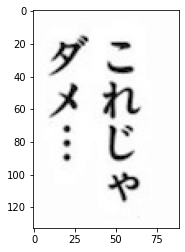

2 かな
2 Wonder


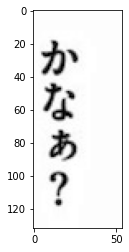

3 コ素一一村皿?
3 Koichi Ichimura plate?


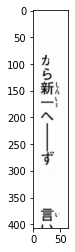

In [0]:
w=10
h=10
# fig=plt.figure(figsize=(10, 10))
length = len(crop_page[0])
cols = 5
rows = int(np.ceil(length/cols))
for i in range(1, cols*rows +1):
    if i>length-1:
        break
#     fig.add_subplot(rows, cols, i)
    plt.imshow(crop_page[0][i])
#     plt.imshow(cv2.threshold(crop_page[0][i],115,255,cv2.THRESH_BINARY)[1])
    print("{}".format(i),ocr_page[0][i])
    print("{}".format(i),ocr_page_tran[0][i])
    plt.show()

In [0]:
# Word Level fill in 
def text_fill(image, axis, text, mask, bg_color):
    
    # Turn the image into array
    im_array = np.array(image)
    im_array[mask==1] = bg_color
    masked_im = Image.fromarray(im_array)
    
    if image.size[0]>3000:
        font_size = 30
        
    # Set default font_size to 12
    font_size = 15
    font = ImageFont.truetype("mangat.ttf", font_size)
    space = 5
    # return im_array
    for coord, t in zip(axis[0],text):

        # Set default text color to white
        text_color = 0
        # Set default background to white
        bg = bg_color
        # Calculate the width and height of text bubbles
        width = coord[2]-coord[0]
        height = coord[3]-coord[1]

        if im_array[coord[1]:coord[3],coord[0]:coord[2]].mean()<100:
            bg = bg_color
            text_color = 0
        # Create a new image size equal to the text box

        img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(img)
        # Set default coordinates for drawing to 0
        v_coord = 0
        h_coord = 0
        words = t.split()
#         draw.text((v_coord, h_coord), words[0], text_color, font=font)
        if not words:
            words = ['....']
#         print(words)
        lst_word_len, word_height = font.getsize(words[0])
        
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
#             print(width,h_coord,v_coord,font_width,space)
#             print((width-h_coord)<(font_width+space))
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len, word_height = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
                
        gap = (height-v_coord)/2-word_height        
#         img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(masked_im)
        # Set default coordinates for drawing to 0
        v_coord = gap
        h_coord = 0
#         print(gap)
        font_size = 15
        
        font = ImageFont.truetype("mangat.ttf", font_size)
        if gap>40:
            font_size = 15
            font = ImageFont.truetype("mangat.ttf", font_size)
        words = t.split()
        if not words:
            words = ['....']
        draw.text((h_coord+coord[0], v_coord+coord[1]), words[0], text_color, font=font)
        lst_word_len,_ = font.getsize(words[0])
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
        
    return masked_im

In [0]:
bg_color

253.0

In [0]:
masked_im = text_fill(img_load, text_box_clean, list(ocr_page_tran[0]), mask,int(bg_color))

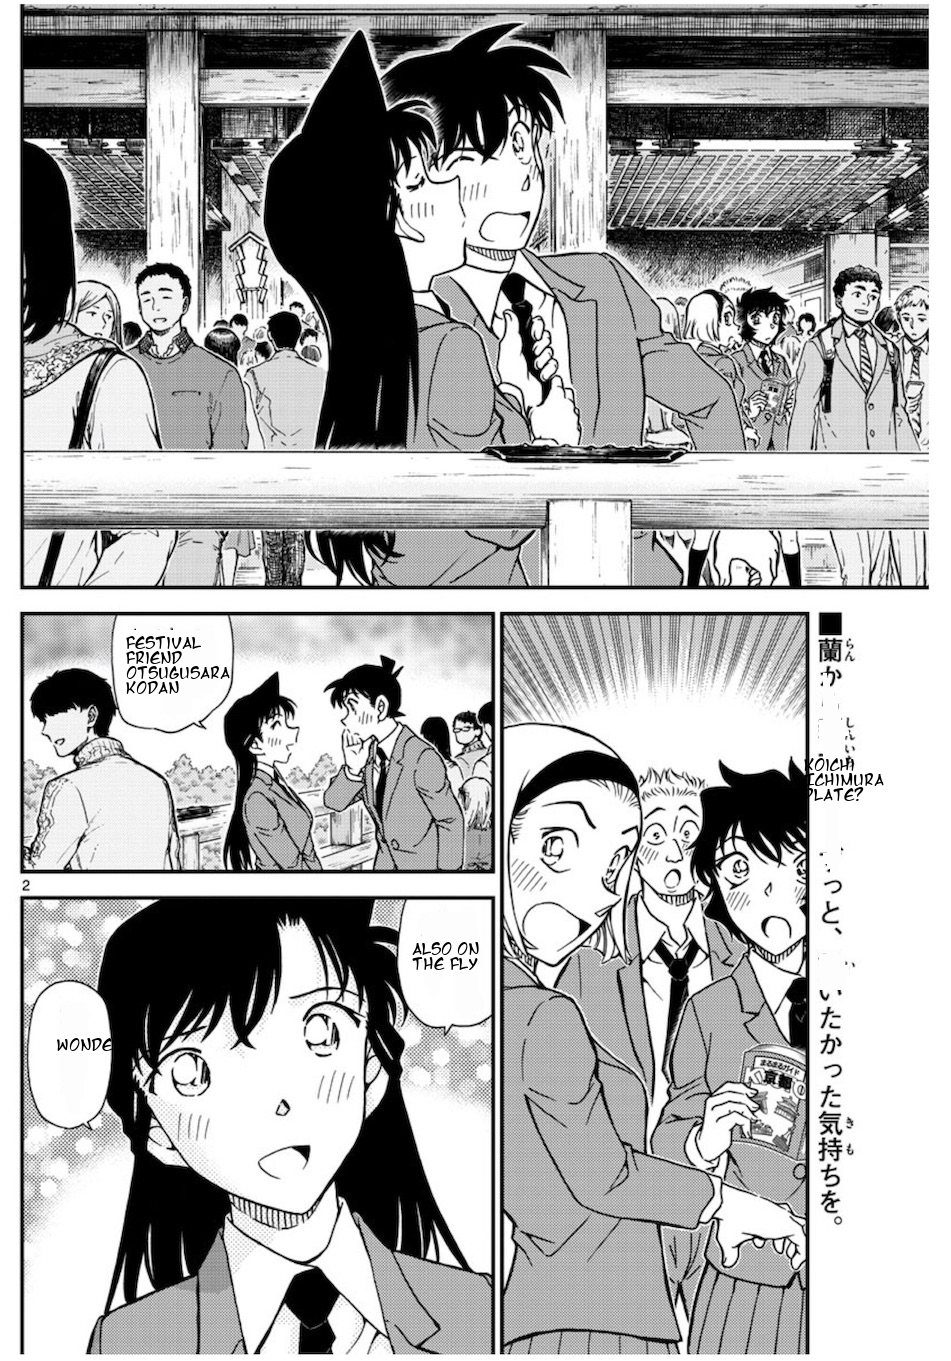

In [0]:
masked_im

In [0]:
def demo_mark(masked_im):
    # Open the original image
    main = masked_im

    # Create a new image for the watermark with an alpha layer (RGBA)
    #  the same size as the original image
    watermark = Image.new("RGB", main.size)
    # Get an ImageDraw object so we can draw on the image
    waterdraw = ImageDraw.ImageDraw(watermark, "RGB")
    # Place the text at (10, 10) in the upper left corner. Text will be white.

    width, height = masked_im.size
    
    if width < 400:
        fontsize = 32
    elif width < 600:
        fontsize = 48
    elif width < 800:
        fontsize = 64
    elif width < 1000:
        fontsize = 80
    elif width < 1200:
        fontsize = 100
    elif width < 1400:
        fontsize =128
    elif width < 1800:
        fontsize= 156
    elif width < 2200:
        fontsize = 192
    elif width < 2600:
        fontsize = 256
    elif width < 3100:
        fontsize = 300
    else:
        fontsize=300
    
#     print(width, height, fontsize)
    
    font_path ="mangat.ttf"
    font = ImageFont.truetype(font_path, int(fontsize*2))
    text = "D  E  M  O"
    text_w,text_h = font.getsize(text)
    
    waterdraw.text([(width-text_w)/2,(height-text_h)/2], text, fill=(128,128,128,128), font=font)
    textRotate = watermark.rotate(30)
    
    
    rLen = math.sqrt((text_w/2)**2+(text_h/2)**2)   
    oriAngle = math.atan(text_h/text_w)
    cropW = rLen*math.cos(oriAngle + math.pi/6) *2
    cropH = rLen*math.sin(oriAngle + math.pi/6) *2
    box = [int((width-cropW)/2-1)-50,int((height-cropH)/2-1)-50,int((width+cropW)/2+1)+50,int((height+cropH)/2+1)]
    textIm = textRotate.crop(box)
#     return textIm
    
    pasteW,pasteH = textIm.size
    textBlank = Image.new("RGB",(width,height))
    pasteBox = (int((width-pasteW)/2-1),int((height-pasteH)/2-1))
    textBlank.paste(textIm,pasteBox)
    
    watermask = textBlank.convert("L").point(lambda x: min(x, 100))
#     return watermask
#     # Apply this mask to the watermark image, using the alpha filter to 
#     #  make it transparent
    watermark.putalpha(watermask)
#     # Paste the watermark (with alpha layer) onto the original image and save it
    main.paste(watermark, None, watermark)
    return main

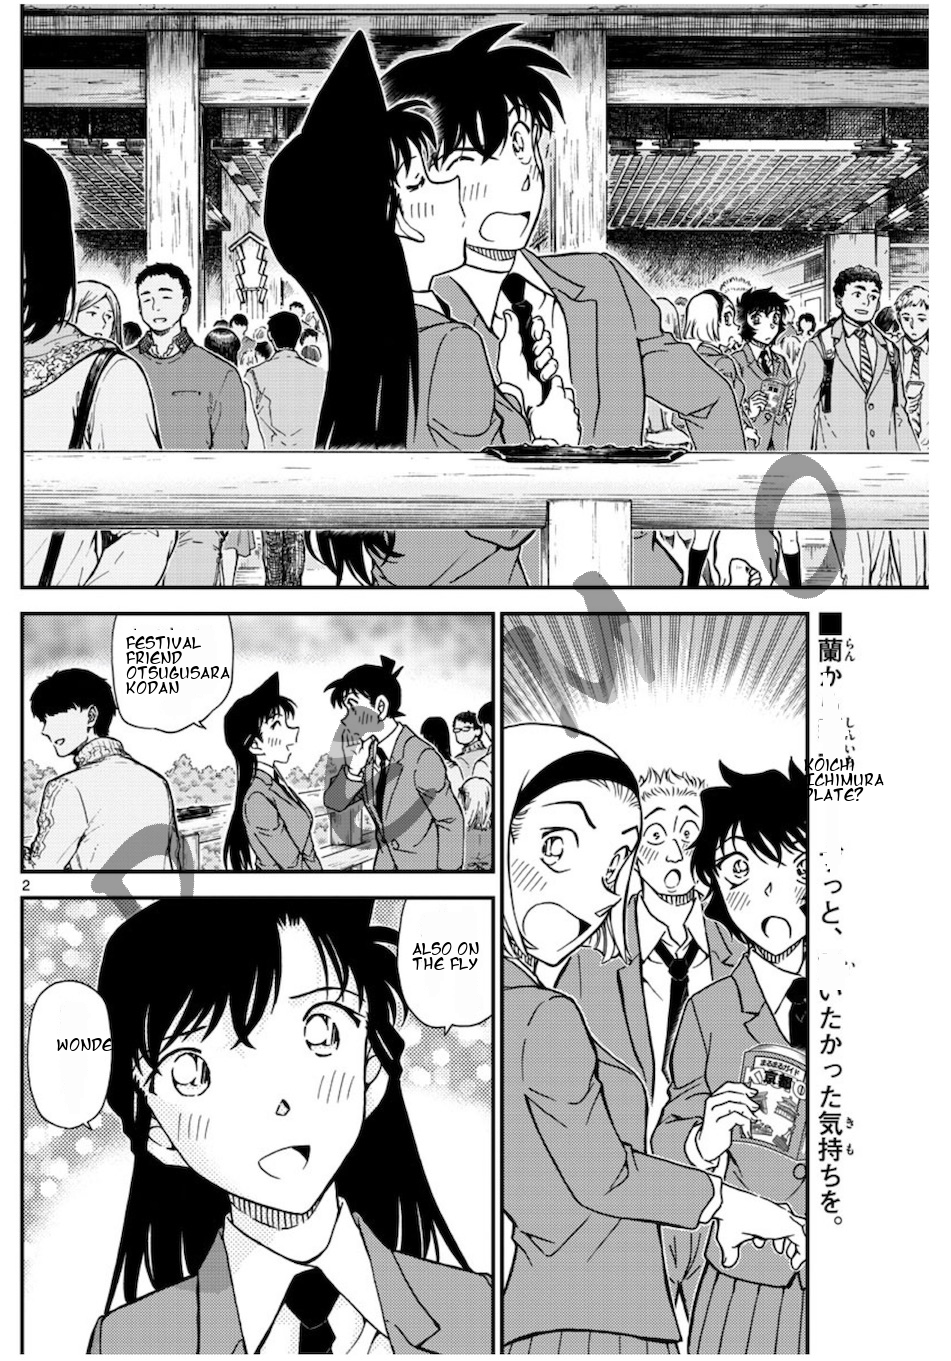

In [0]:
demo_mark(masked_im)